# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
from collections import defaultdict
import re

In [62]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [5]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
FREQ=60
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [6]:



INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 1
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.1

TRIAL_TIME_STAMP_DURATION = 1000*10

In [7]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [8]:
all_session_dir = ['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
'/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

In [9]:
all_session_dir

['/scratch/back_up/reward_competition_extention/data/standard/2023_06_12/20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_20/20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221214_125409_om_and_comp_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/pilot/20221215_145401_comp_amd_om_6_1_and_6_3.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [10]:
def nested_dict():
    return defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [11]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [12]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     6.1       NaN        15       14      13      31   
1       1     6.2       NaN        15       14      13      31   
2       1     6.3       NaN        15       14      13      31   
3       1     6.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                  21.0                  15.0                 14.0   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   9.0                  31.0                 30.0   
7                  15.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                13.0                16.0  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                29.0                28.0  
7                29.0                28.0

### Getting the subject IDs from the file name

In [13]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [14]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

- Original timestamps are based on ephys recordings at 20kHz. The LFP will be at 1kHz, so we will need to divide all the timestamps by 20

In [15]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [16]:
all_trials_df["recording_dir"].unique()

array(['20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
       '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2',
       '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
       '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
       '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
       '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
       '20221215_145401_comp_amd_om_6_1_and_6_3',
       '20221202_134600_omission_and_competition_subject_6_1_and_6_2',
       '20221214_125409_om_and_comp_6_1_and_6_3'], dtype=object)

- Getting a list of all the subjects through the recording name

In [17]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: ["{}.{}".format(tup[0],tup[1]) for tup in re.findall(r'(\d+)-(\d+)', x.replace("_", "-"))[1:]])

In [18]:
all_trials_df["all_subjects"].head()

0    [1.4, 1.3]
1    [1.4, 1.3]
2    [1.4, 1.3]
3    [1.4, 1.3]
4    [1.4, 1.3]
Name: all_subjects, dtype: object

- Getting the current subject of the recording through the ending of the recording name file

In [19]:
all_trials_df["subject_info"].head()

0    1-3_t3b3L_box2
1    1-3_t3b3L_box2
2    1-3_t3b3L_box2
3    1-3_t3b3L_box2
4    1-3_t3b3L_box2
Name: subject_info, dtype: object

In [20]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [21]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject  
0         NaN          49111.0   [1.4, 1.3]             1.3  
1         NaN         169111.0   [1.4, 1.3]             1.3  
2         NaN         284111.0   [1.4, 1.3]             1.3  
3         NaN         374111.0   [1.4, 1.3]             1.3  
4         NaN         429111.0   [1.4, 1.3]             1.3

- Labeling the trial as a winner or loser if the winner matches the subject id or not

In [22]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [23]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          49111.0   [1.4, 1.3]             1.3          lose  
1         NaN         169111.0   [1.4, 1.3]             1.3           win  
2         NaN         284111.0   [1.4, 1.3]             1.3          lose  
3         NaN         374111.0   [1.4, 1.3]             1.3          lose  
4         NaN         429111.0   [1.4, 1.3]             1.3          lose

In [24]:
all_trials_df

time  state                                      recording_dir  \
0     9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1    12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2    14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3    16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4    17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
..          ...    ...                                                ...   
636  56250471.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
637  58050469.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
638  59950467.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
639  62350467.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   
640  63950466.0    1.0            20221214_125409_om_and_comp_6_1_and_6_3   

                                        recording_file           din  \
0    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4    20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
..                                                 ...           ...   
636  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
637  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
638  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
639  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
640  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

     time_stamp_index                                         video_file  \
0            982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1           3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2           5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3           7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4           8582220.0  20230612_101430_standard_comp_to_training_D1_s...   
..                ...                                                ...   
636        53298568.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
637        55098566.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
638        56998564.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
639        59398564.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
640        60998563.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

     video_frame  video_number             subject_info condition  \
0          980.0           2.0           1-3_t3b3L_box2       1.4   
1         3376.0           2.0           1-3_t3b3L_box2       1.3   
2         5671.0           2.0           1-3_t3b3L_box2       1.4   
3         7468.0           2.0           1-3_t3b3L_box2       1.4   
4         8566.0           2.0           1-3_t3b3L_box2       1.4   
..           ...           ...                      ...       ...   
636      60112.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   
637      62355.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   
638      64724.0           1.0  6_1_top_1_base_2_vs_6_3       6.1   
639      67716.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   
640      69710.0           1.0  6_1_top_1_base_2_vs_6_3       6.3   

    competition_closeness Unnamed: 13  resampled_index all_subjects  \
0             Subj 2 Only         NaN          49111.0   [1.4, 1.3]   
1             Subj 1 Only         NaN         169111.0   [1.4, 1.3]   
2             Subj 2 Only         NaN         284111.0   [1.4, 1.3]   
3             Subj 2 Only         NaN         374111.0   [1.4, 1.3]   
4             Subj 2 Only         NaN         429111.0   [1.4, 1.3]   
..                    ...         ...              ..

### Extracting the LFP

In [25]:
recording_name_to_all_ch_lfp = {}
# Going through all the recording sessions 
for session_dir in all_session_dir:
    # Going through all the recordings in each session
    for recording_path in glob.glob(os.path.join(session_dir, "*.rec")):
        try:
            recording_basename = os.path.splitext(os.path.basename(recording_path))[0]
            # checking to see if the recording has an ECU component
            # if it doesn't, then the next one be extracted
            current_recording = se.read_spikegadgets(recording_path, stream_id="ECU")
            current_recording = se.read_spikegadgets(recording_path, stream_id="trodes")
            print(recording_basename)
            # Preprocessing the LFP
            current_recording = sp.bandpass_filter(current_recording, freq_min=0.5, freq_max=300)
            current_recording = sp.notch_filter(current_recording, freq=60)
            current_recording = sp.resample(current_recording, resample_rate=1000)
            recording_name_to_all_ch_lfp[recording_basename] = current_recording
        except:
            pass



20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged
20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3
20221215_145401_comp_amd_om_6_1_top_4_base_3
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged


- Filtering for all trials that have labels

In [26]:
all_trials_df = all_trials_df[all_trials_df["recording_file"].isin(recording_name_to_all_ch_lfp.keys())].reset_index(drop=True)

In [27]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          49111.0   [1.4, 1.3]             1.3          lose  
1         NaN         169111.0   [1.4, 1.3]             1.3           win  
2         NaN         284111.0   [1.4, 1.3]             1.3          lose  
3         NaN         374111.0   [1.4, 1.3]             1.3          lose  
4         NaN         429111.0   [1.4, 1.3]             1.3          lose

In [28]:
all_trials_df["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [29]:
recording_name_to_all_ch_lfp.keys()

dict_keys(['20230612_101430_standard_comp_to_training_D1_subj_1-4_t4b2L_box1_merged', '20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged', '20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged', '20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3', '20221215_145401_comp_amd_om_6_1_top_4_base_3', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged'])

In [30]:
CHANNEL_MAPPING_DF

Cohort Subject  eib_mPFC  eib_vHPC  eib_BLA  eib_LH  eib_MD  \
0       1     6.1       NaN        15       14      13      31   
1       1     6.2       NaN        15       14      13      31   
2       1     6.3       NaN        15       14      13      31   
3       1     6.4       NaN        15       14      13      31   
4       2     1.1       NaN        16       17      18      19   
5       2     1.2       NaN        31       30      29      28   
6       2     1.3       NaN        15       14      13      12   
7       2     1.4       NaN        15       14      13      12   

   spike_interface_mPFC  spike_interface_vHPC  spike_interface_BLA  \
0                  21.0                  15.0                 14.0   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   5.0                  31.0                 30.0   
5                  10.0                  31.0                 30.0   
6                   9.0                  31.0                 30.0   
7                  15.0                  31.0                 30.0   

   spike_interface_LH  spike_interface_MD  
0                13.0                16.0  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                29.0                28.0  
5                29.0                28.0  
6                29.0                28.0  
7                29.0                28.0

## Power Calculation

In [31]:
all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info condition competition_closeness  \
0        980.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
1       3376.0           2.0  1-3_t3b3L_box2       1.3           Subj 1 Only   
2       5671.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
3       7468.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   
4       8566.0           2.0  1-3_t3b3L_box2       1.4           Subj 2 Only   

  Unnamed: 13  resampled_index all_subjects current_subject trial_outcome  
0         NaN          49111.0   [1.4, 1.3]             1.3          lose  
1         NaN         169111.0   [1.4, 1.3]             1.3           win  
2         NaN         284111.0   [1.4, 1.3]             1.3          lose  
3         NaN         374111.0   [1.4, 1.3]             1.3          lose  
4         NaN         429111.0   [1.4, 1.3]             1.3          lose

- Adding all the brain region to ch information

In [32]:
channel_map_and_all_trials_df = all_trials_df.merge(CHANNEL_MAPPING_DF, left_on="current_subject", right_on="Subject", how="left")

- Linking up all LFP calculations with all the trials

In [33]:
channel_map_and_all_trials_df["all_ch_lfp"] = channel_map_and_all_trials_df["recording_file"].map(recording_name_to_all_ch_lfp)

- Creating a new row for each brain region

In [34]:
brain_region_col = [col for col in CHANNEL_MAPPING_DF if "spike_interface" in col]

In [35]:
id_cols = [col for col in channel_map_and_all_trials_df.columns if col not in brain_region_col]

In [36]:
melted_channel_map_and_all_trials_df = channel_map_and_all_trials_df.melt(id_vars=id_cols ,value_vars=brain_region_col, var_name='brain_region', value_name='channel')


In [37]:
melted_channel_map_and_all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info  ... Cohort Subject eib_mPFC  \
0        980.0           2.0  1-3_t3b3L_box2  ...      2     1.3      NaN   
1       3376.0           2.0  1-3_t3b3L_box2  ...      2     1.3      NaN   
2       5671.0           2.0  1-3_t3b3L_box2  ...      2     1.3      NaN   
3       7468.0           2.0  1-3_t3b3L_box2  ...      2     1.3      NaN   
4       8566.0           2.0  1-3_t3b3L_box2  ...      2     1.3      NaN   

   eib_vHPC eib_BLA eib_LH eib_MD  \
0        15      14     13     12   
1        15      14     13     12   
2        15      14     13     12   
3        15      14     13     12   
4        15      14     13     12   

                                          all_ch_lfp          brain_region  \
0  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
1  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
2  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
3  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
4  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   

   channel  
0      9.0  
1      9.0  
2      9.0  
3      9.0  
4      9.0  

[5 rows x 27 columns]

In [38]:
melted_channel_map_and_all_trials_df.tail()

time  state                            recording_dir  \
2645  56250471.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2646  58050469.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2647  59950467.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2648  62350467.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   
2649  63950466.0    1.0  20221214_125409_om_and_comp_6_1_and_6_3   

                                         recording_file           din  \
2645  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2646  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2647  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2648  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   
2649  20221214_125409_om_and_comp_6_1_top_1_base_2_v...  dio_ECU_Din1   

      time_stamp_index                                         video_file  \
2645        53298568.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2646        55098566.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2647        56998564.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2648        59398564.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   
2649        60998563.0  20221214_125409_om_and_comp_6_1_and_6_3.1.vide...   

      video_frame  video_number             subject_info  ... Cohort Subject  \
2645      60112.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
2646      62355.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
2647      64724.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
2648      67716.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   
2649      69710.0           1.0  6_1_top_1_base_2_vs_6_3  ...      1     6.1   

     eib_mPFC  eib_vHPC eib_BLA eib_LH eib_MD  \
2645      NaN        15      14     13     31   
2646      NaN        15      14     13     31   
2647      NaN        15      14     13     31   
2648      NaN        15      14     13     31   
2649      NaN        15      14     13     31   

                                             all_ch_lfp        brain_region  \
2645  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
2646  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
2647  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
2648  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   
2649  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_MD   

      channel  
2645     16.0  
2646     16.0  
2647     16.0  
2648     16.0  
2649     16.0  

[5 rows x 27 columns]

- Getting the traces for each trial for each brain region

In [39]:
melted_channel_map_and_all_trials_df["channel"] = melted_channel_map_and_all_trials_df["channel"].astype(int).astype(str)
melted_channel_map_and_all_trials_df["resampled_index"] = melted_channel_map_and_all_trials_df["resampled_index"].astype(int)

In [40]:
melted_channel_map_and_all_trials_df["trial_trace"] = melted_channel_map_and_all_trials_df.apply(lambda x: x["all_ch_lfp"].get_traces(channel_ids=[x["channel"]], start_frame=x["resampled_index"], end_frame=x["resampled_index"] + RESAMPLE_RATE * TRIAL_DURATION).T[0], axis=1)

In [41]:
melted_channel_map_and_all_trials_df["trial_trace"] = melted_channel_map_and_all_trials_df["trial_trace"].apply(lambda x: x[:RESAMPLE_RATE*TRIAL_DURATION])

- Calcuating the power at each frequency band

In [42]:
melted_channel_map_and_all_trials_df["multitaper"] = melted_channel_map_and_all_trials_df["trial_trace"].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE))

In [43]:
melted_channel_map_and_all_trials_df["connectivity"] = melted_channel_map_and_all_trials_df["multitaper"].apply(lambda x: Connectivity.from_multitaper(x))

In [44]:
melted_channel_map_and_all_trials_df["frequencies"] = melted_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.frequencies)

In [45]:
melted_channel_map_and_all_trials_df["power"] = melted_channel_map_and_all_trials_df["connectivity"].apply(lambda x: x.power().squeeze())

In [46]:
melted_channel_map_and_all_trials_df.head()

time  state                                      recording_dir  \
0   9781115.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
1  12181113.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
2  14481111.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
3  16281110.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   
4  17381106.0    1.0  20230612_101430_standard_comp_to_training_D1_s...   

                                      recording_file           din  \
0  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
1  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
2  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
3  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   
4  20230612_101430_standard_comp_to_training_D1_s...  dio_ECU_Din1   

   time_stamp_index                                         video_file  \
0          982229.0  20230612_101430_standard_comp_to_training_D1_s...   
1         3382227.0  20230612_101430_standard_comp_to_training_D1_s...   
2         5682225.0  20230612_101430_standard_comp_to_training_D1_s...   
3         7482224.0  20230612_101430_standard_comp_to_training_D1_s...   
4         8582220.0  20230612_101430_standard_comp_to_training_D1_s...   

   video_frame  video_number    subject_info  ... eib_LH eib_MD  \
0        980.0           2.0  1-3_t3b3L_box2  ...     13     12   
1       3376.0           2.0  1-3_t3b3L_box2  ...     13     12   
2       5671.0           2.0  1-3_t3b3L_box2  ...     13     12   
3       7468.0           2.0  1-3_t3b3L_box2  ...     13     12   
4       8566.0           2.0  1-3_t3b3L_box2  ...     13     12   

                                          all_ch_lfp          brain_region  \
0  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
1  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
2  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
3  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   
4  ResampleRecording: 32 channels - 1 segments - ...  spike_interface_mPFC   

  channel                                        trial_trace  \
0       9  [223, 529, 443, 239, 174, 142, -26, -226, -308...   
1       9  [-971, -914, -1041, -1118, -950, -793, -783, -...   
2       9  [-51, -30, -87, -174, -189, -159, -217, -305, ...   
3       9  [252, 220, 231, 235, 190, 228, 371, 465, 448, ...   
4       9  [-231, -252, -305, -269, -180, -157, -189, -20...   

                                          multitaper  \
0  Multitaper(sampling_frequency=1000, time_halfb...   
1  Multitaper(sampling_frequency=1000, time_halfb...   
2  Multitaper(sampling_frequency=1000, time_halfb...   
3  Multitaper(sampling_frequency=1000, time_halfb...   
4  Multitaper(sampling_frequency=1000, time_halfb...   

                                        connectivity  \
0  <spectral_connectivity.connectivity.Connectivi...   
1  <spectral_connectivity.connectivity.Connectivi...   
2  <spectral_connectivity.connectivity.Connectivi...   
3  <spectral_connectivity.connectivity.Connectivi...   
4  <spectral_connectivity.connectivity.Connectivi...   

                                         frequencies  \
0  [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...   
1  [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...   
2  [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...   
3  [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...   
4  [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...   

                                               power  
0  [23.95542869622485, 83.74684067193519, 716.107...  
1  [912.5402773924279, 1102.8212847013326, 8942.8...  
2  [10.660457325975605, 10.905774447408797, 45.39...  
3  [133.76964308711703, 143.08165890468314, 304.7...  
4  [18.33349320266428, 34.840008731358736, 273.66...  

[5 rows x 32 columns]

In [52]:
grouped_all_trials_df = melted_channel_map_and_all_trials_df.groupby(['brain_region', 'trial_outcome', 'recording_file', 'current_subject']).agg({'power': lambda x: np.vstack(x.tolist())}).reset_index()

In [54]:
grouped_all_trials_df["mean_power"] = grouped_all_trials_df["power"].apply(lambda x: np.mean(np.vstack(x), axis=0))

In [55]:
grouped_all_trials_df["sem_power"] = grouped_all_trials_df["power"].apply(lambda x: np.std(np.vstack(x), axis=0) / np.sqrt(np.vstack(x).shape[0]))

In [64]:
melted_channel_map_and_all_trials_df["frequencies"].iloc[0]

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 4.997e+02, 4.998e+02,
       4.999e+02])

In [77]:
color_list = ["b", "g", "r", "m", "y", "pink", "purple"]

In [78]:
id_to_color = { id: color_list[index] for index, id in enumerate(sorted(grouped_all_trials_df["current_subject"].unique()))}

In [79]:
id_to_color

{'1.1': 'b', '1.2': 'g', '1.3': 'r', '1.4': 'm', '6.1': 'y'}

In [84]:
outcome_to_style = {'lose': "solid", 'omission': "dotted", 'rewarded': "dotted", 'win': "solid"}

In [86]:
outcome_to_style = {'lose': "-", 'omission': "--", 'rewarded': "-", 'win': "--"}

In [91]:
outcome_to_style = {'lose': "solid", 'omission': "dashed", 'rewarded': "dashed", 'win': "solid"}

In [83]:
grouped_all_trials_df["trial_outcome"].unique()

array(['lose', 'omission', 'rewarded', 'win'], dtype=object)

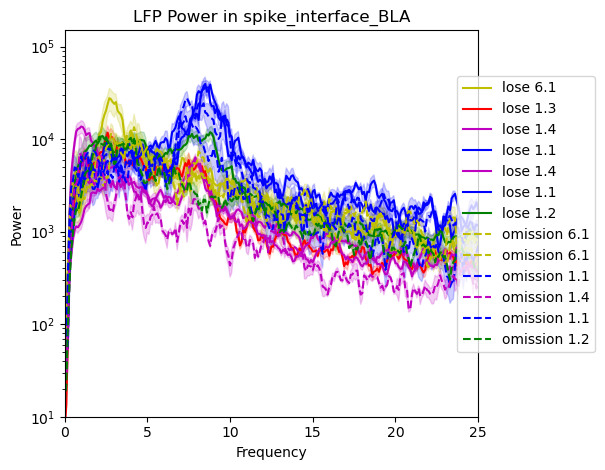

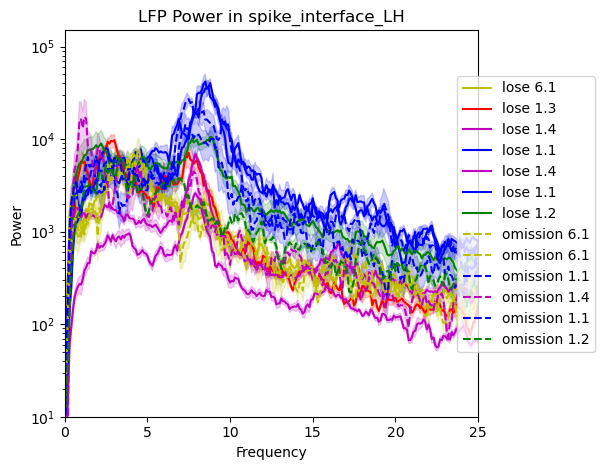

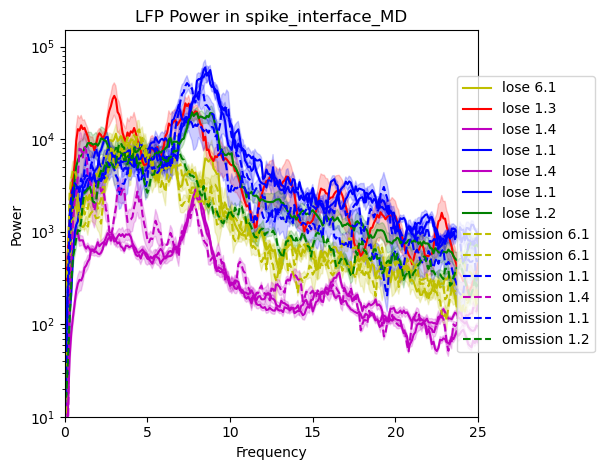

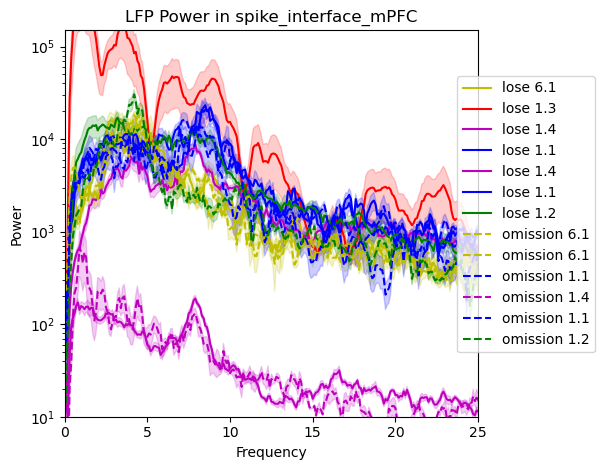

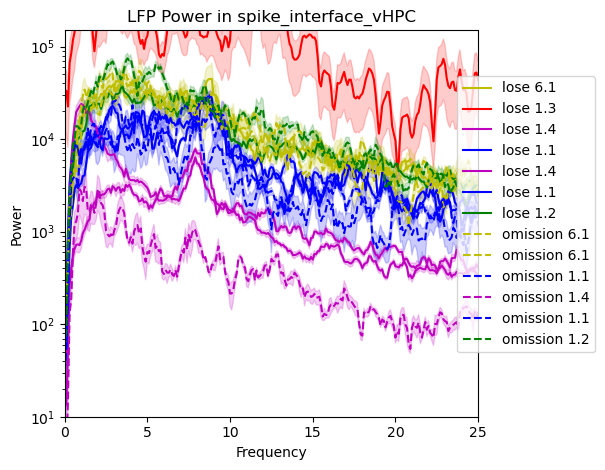

In [119]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    fig, ax = plt.subplots()
    plt.title("LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 25)
    plt.ylim(10, 150000)
    plt.yscale("log")
    for outcome in ["lose", "omission"]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, row["current_subject"]), color=id_to_color[row["current_subject"]], linestyle=outcome_to_style[outcome])
            # ax.lines[0].set_linestyle(outcome_to_style[outcome])
            plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=id_to_color[row["current_subject"]])
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()
    plt.savefig("./proc/lose_and_omission_for_{}.png".format(region))
    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

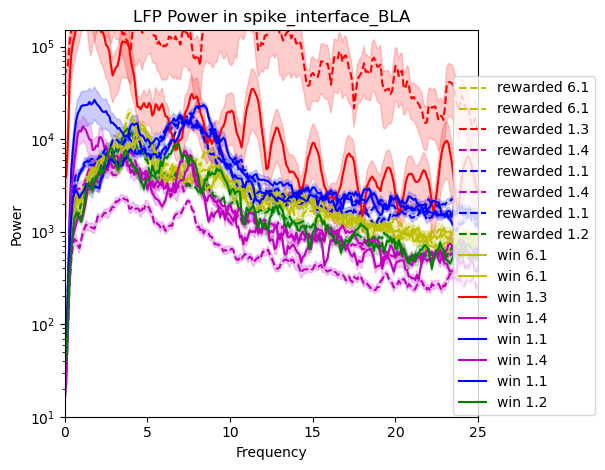

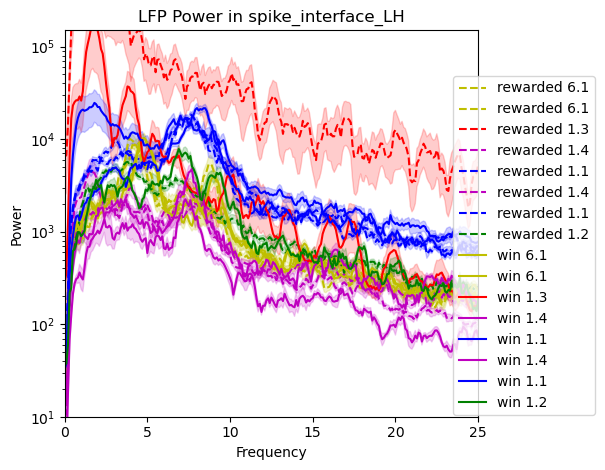

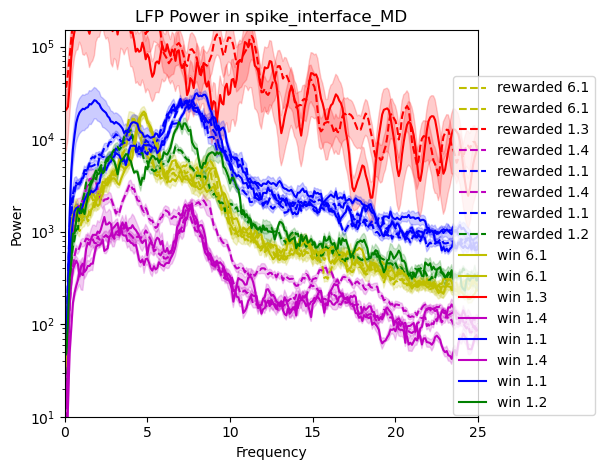

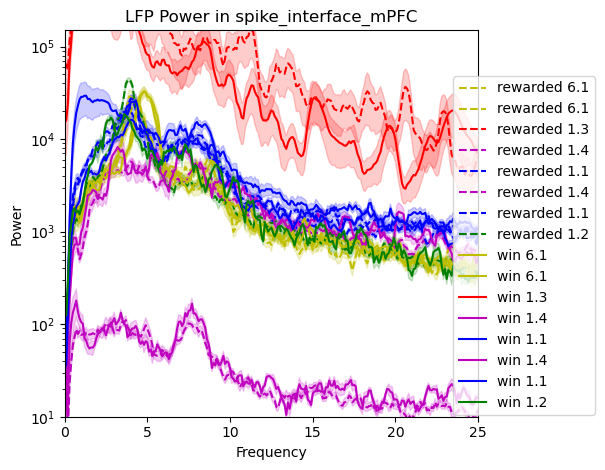

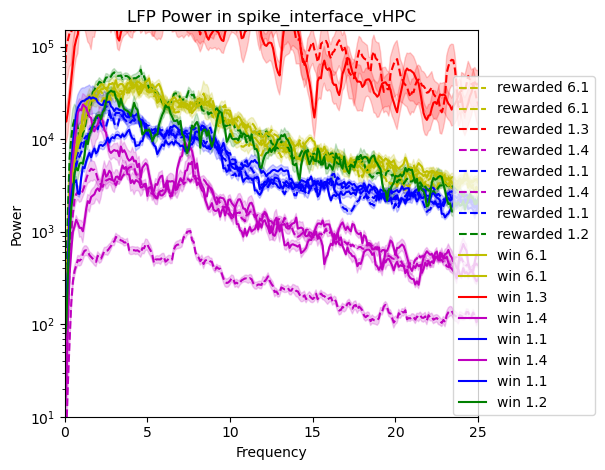

In [120]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    fig, ax = plt.subplots()
    plt.title("LFP Power in {}".format(region))
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.xlim(0, 25)
    plt.ylim(10, 150000)
    plt.yscale("log")
    for outcome in ["rewarded", "win"]:
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            ax = sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label="{} {}".format(outcome, row["current_subject"]), color=id_to_color[row["current_subject"]], linestyle=outcome_to_style[outcome])
            # ax.lines[0].set_linestyle(outcome_to_style[outcome])
            plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=id_to_color[row["current_subject"]])
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right')
    plt.tight_layout()

    plt.savefig("./proc/win_and_rewarded_for_{}.png".format(region))

    # # Removing duplicate labels in the legend
    # handles, labels = plt.gca().get_legend_handles_labels()
    # unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    # plt.legend(*zip(*unique))

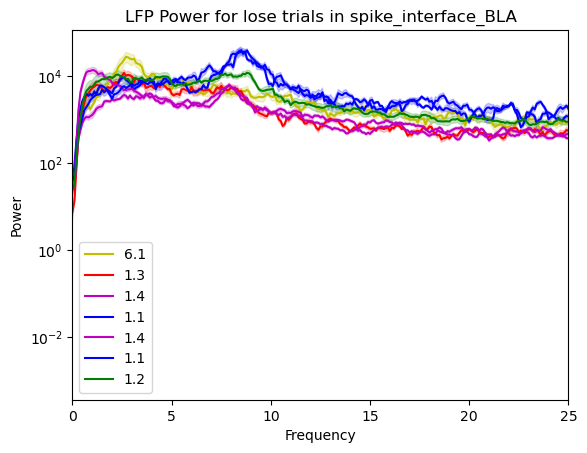

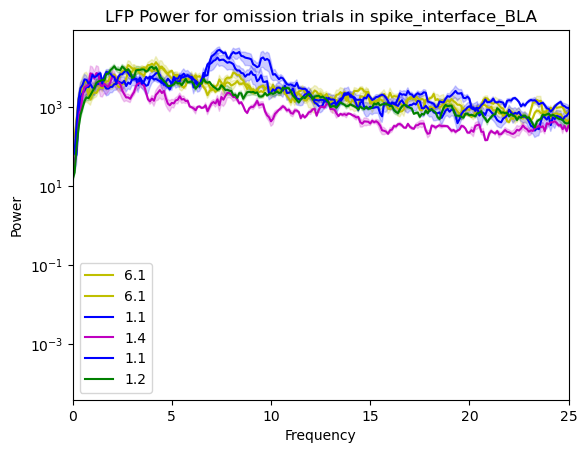

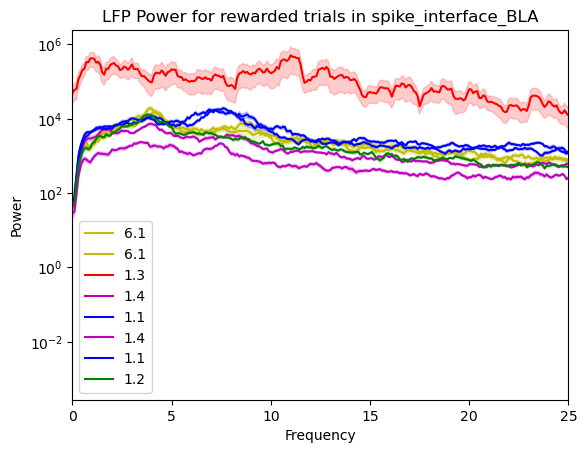

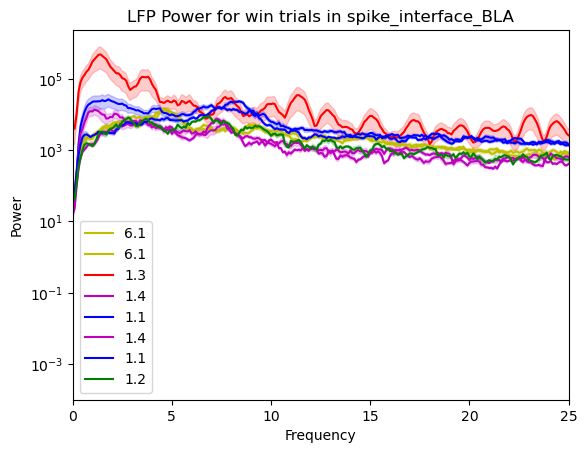

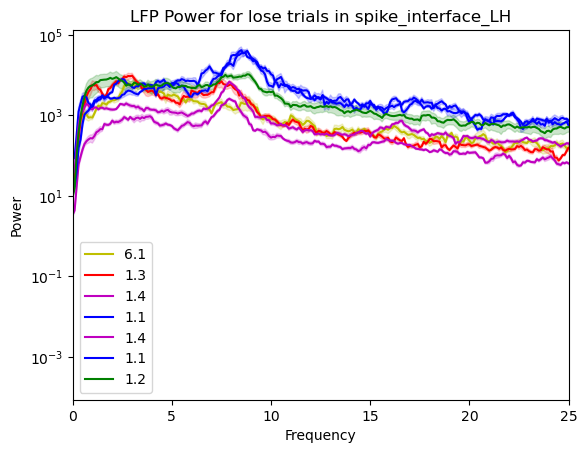

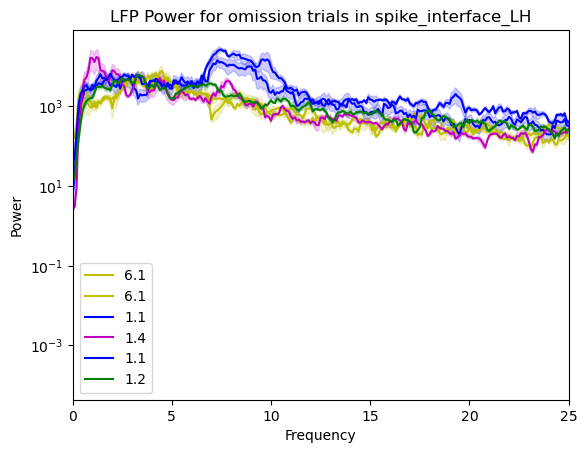

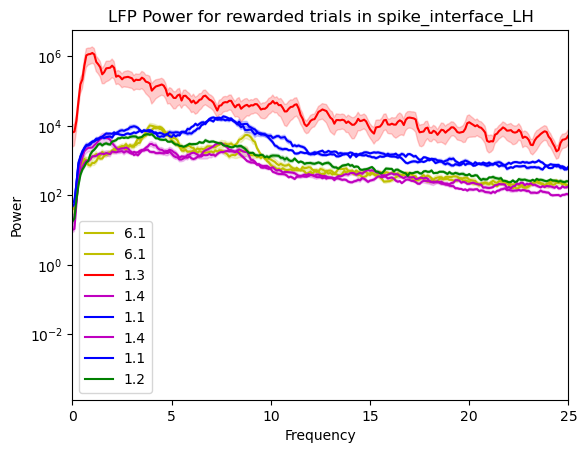

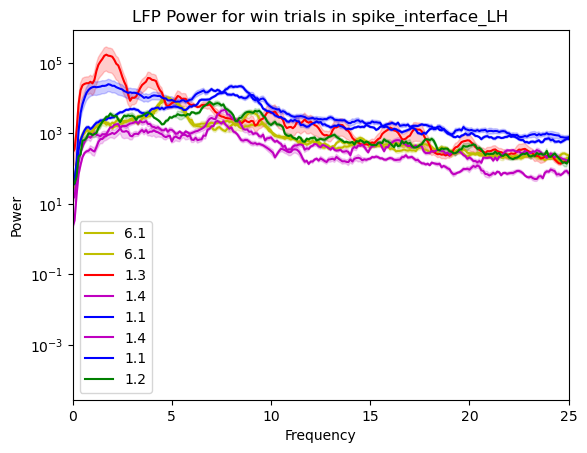

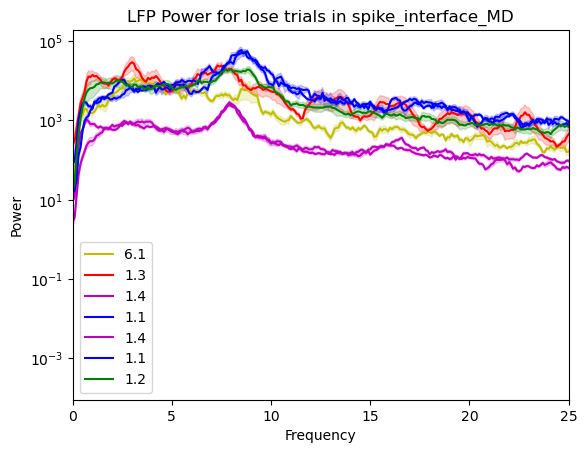

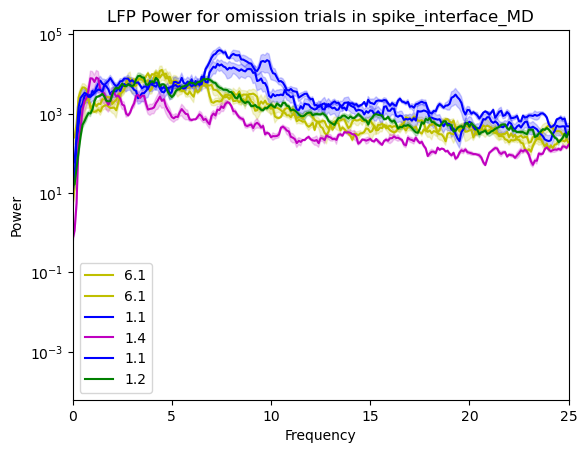

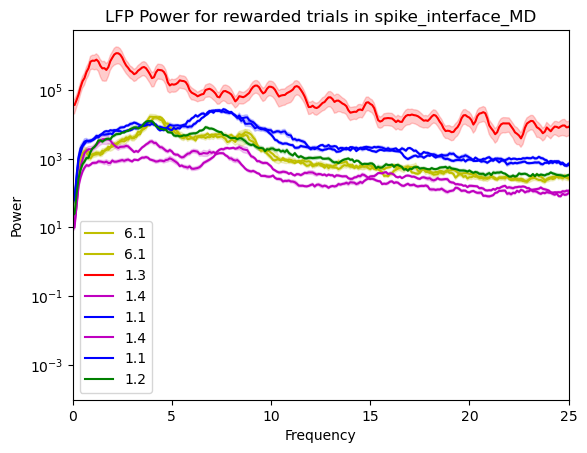

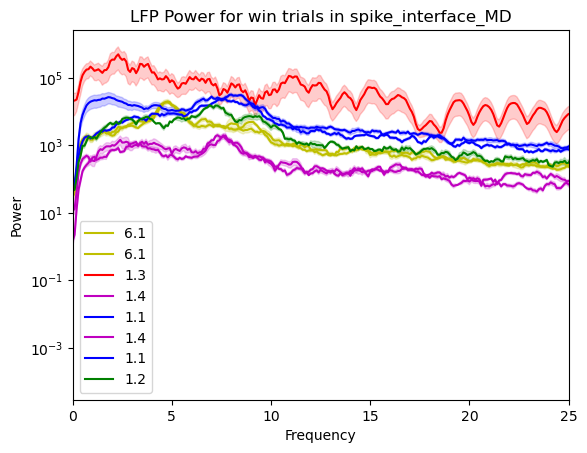

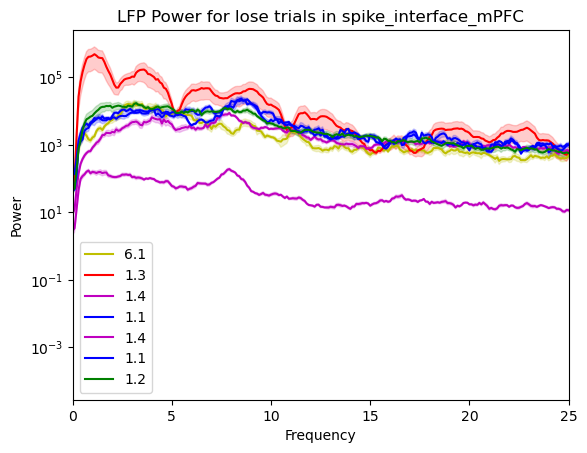

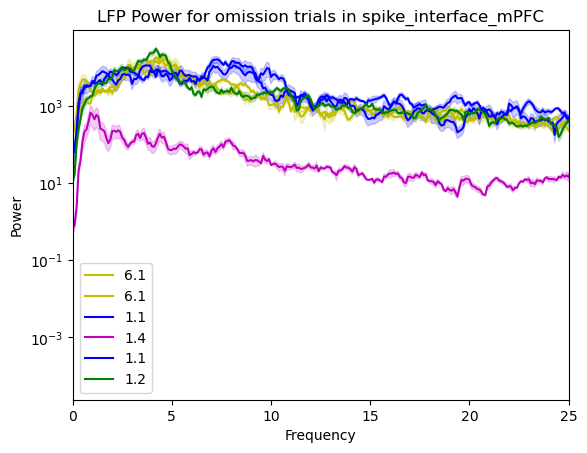

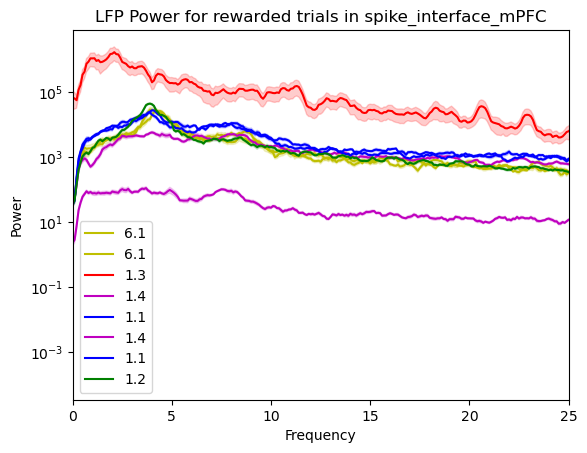

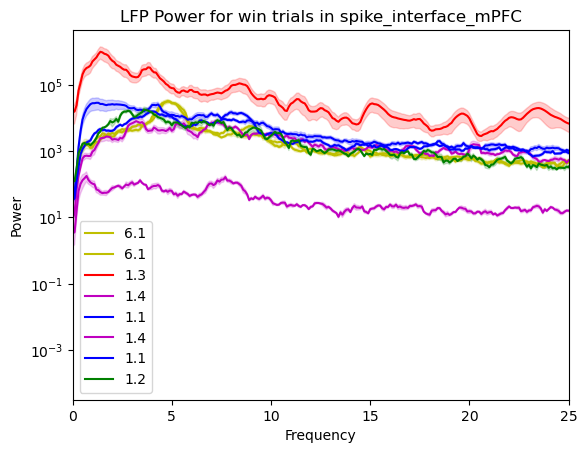

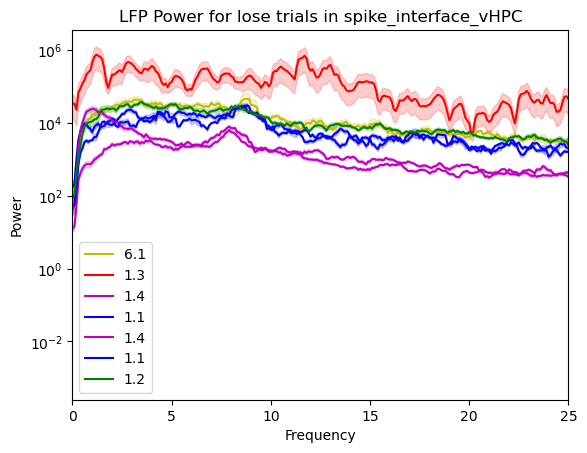

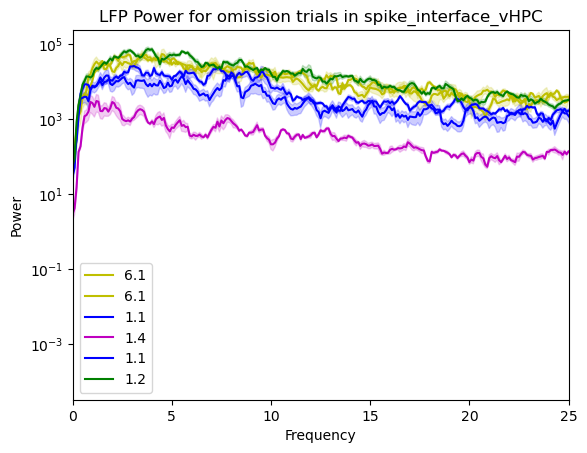

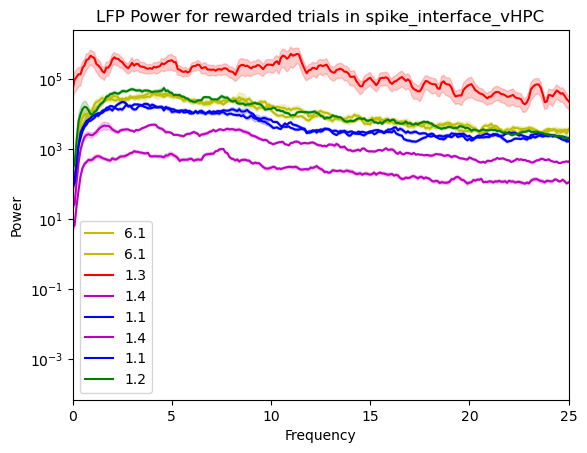

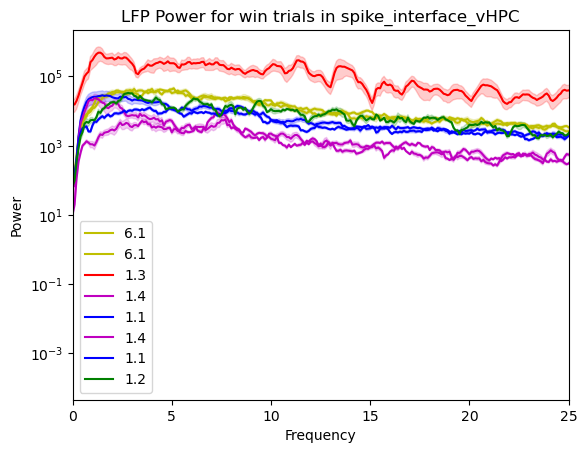

In [81]:
for region in grouped_all_trials_df["brain_region"].unique():
    region_df = grouped_all_trials_df[grouped_all_trials_df["brain_region"] == region]
    for outcome in grouped_all_trials_df["trial_outcome"].unique():
        fig, ax = plt.subplots()
        plt.title("LFP Power for {} trials in {}".format(outcome, region))
        plt.xlabel("Frequency")
        plt.ylabel("Power")
        plt.xlim(0, 25)
        plt.yscale("log")
        outcome_df = region_df[region_df["trial_outcome"] == outcome]
        for index, row in outcome_df.iterrows():
            sns.lineplot(x=melted_channel_map_and_all_trials_df["frequencies"].iloc[0], y=row["mean_power"], label=row["current_subject"], color=id_to_color[row["current_subject"]])
            plt.fill_between(melted_channel_map_and_all_trials_df["frequencies"].iloc[0], row["mean_power"] - row["sem_power"], row["mean_power"] + row["sem_power"], alpha=0.2, color=id_to_color[row["current_subject"]])

In [53]:
grouped_all_trials_df

brain_region trial_outcome  \
0     spike_interface_BLA          lose   
1     spike_interface_BLA          lose   
2     spike_interface_BLA          lose   
3     spike_interface_BLA          lose   
4     spike_interface_BLA          lose   
..                    ...           ...   
140  spike_interface_vHPC           win   
141  spike_interface_vHPC           win   
142  spike_interface_vHPC           win   
143  spike_interface_vHPC           win   
144  spike_interface_vHPC           win   

                                        recording_file current_subject  \
0    20221214_125409_om_and_comp_6_1_top_1_base_2_v...             6.1   
1    20230612_101430_standard_comp_to_training_D1_s...             1.3   
2    20230612_101430_standard_comp_to_training_D1_s...             1.4   
3    20230618_100636_standard_comp_to_omission_D2_s...             1.1   
4    20230618_100636_standard_comp_to_omission_D2_s...             1.4   
..                                                 ...             ...   
140  20230612_101430_standard_comp_to_training_D1_s...             1.4   
141  20230618_100636_standard_comp_to_omission_D2_s...             1.1   
142  20230618_100636_standard_comp_to_omission_D2_s...             1.4   
143  20230620_114347_standard_comp_to_omission_D4_s...             1.1   
144  20230620_114347_standard_comp_to_omission_D4_s...             1.2   

                                                 power  
0    [[36.41874255918891, 33.786368796523575, 176.7...  
1    [[3.2747411382996847, 11.486686254462507, 72.4...  
2    [[21.61819120009322, 29.638611028423828, 188.6...  
3    [[34.09897886292097, 58.65523525371283, 281.86...  
4    [[223.11126115470353, 225.45175419153344, 428....  
..                                                 ...  
140  [[21.687510925466597, 46.249718895357574, 209....  
141  [[5.169080038035249, 6.31805379940292, 5.05956...  
142  [[4.624596290170551, 5.164965397430586, 29.992...  
143  [[19.76956927823934, 23.32104023077298, 65.023...  
144  [[58.34860806405013, 59.38815098446395, 161.53...  

[145 rows x 5 columns]

In [50]:
raise ValueError()

ValueError: 

In [ ]:
len(c.frequencies)

In [ ]:
np.vstack(current_trials).shape[0]

In [ ]:
color_list = ["b", "g", "r", "c", "m", "y", "pink", "purple"]

In [ ]:
color_list

In [ ]:
sorted(all_recording_dict.keys())

In [ ]:
melted_channel_map_and_all_trials_df["trial_outcome"].unique()

In [ ]:
melted_channel_map_and_all_trials_df["brain_region"].unique()

In [ ]:
melted_channel_map_and_all_trials_df.columns

In [ ]:

for region in melted_channel_map_and_all_trials_df["brain_region"].unique():
    print(region)
    fig, ax = plt.subplots()
    region_df = melted_channel_map_and_all_trials_df[melted_channel_map_and_all_trials_df["brain_region"] == region]
    for recording in melted_channel_map_and_all_trials_df["recording_file"].unique():
        
        continue
        recording_df = region_df[region_df["recording_file"] == recording]
        
        print(recording_df)
        print(recording)
        continue
        mean_power = np.mean(np.vstack(current_trials), axis=0)
        sem_power = np.std(np.vstack(current_trials), axis=0) / np.sqrt(np.vstack(current_trials).shape[0])

In [ ]:
for outcome, all_region_dicts in sorted(condition_to_everything.items()):
    print(outcome)
    
    for region, all_recording_dict in sorted(all_region_dicts.items()):
        print(region)
        
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.set_xlim(1,12)
        # labelLines(ax.get_lines(), zorder=2.5)
        plt.title("LFP Frequency Power for {} with {} trials".format(region, outcome))
        for recording, all_trials in sorted(all_recording_dict.items()):
            color = color_list[sorted(all_recording_dict.keys()).index(recording)]
            if "6_1" in recording:
                subject = "6.1"
            else:
                subject = ".".join(recording.split("subject")[-1].split("subj")[-1].strip("merged").strip("_").replace("-","_").split("_")[:2])
            current_trials = [trials for trials in all_trials if len(trials) == 5000] 
            print(recording)
            print(np.vstack(current_trials).shape)

            mean_power = np.mean(np.vstack(current_trials), axis=0)
            sem_power = np.std(np.vstack(current_trials), axis=0) / np.sqrt(np.vstack(current_trials).shape[0])

            plt.plot(c.frequencies, mean_power, label=subject, color=color)
            plt.fill_between(c.frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3, color=color)
        # Get the handles and labels from the current axes
        handles, labels = plt.gca().get_legend_handles_labels()
        
        # Sort them by labels
        sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: t[1])
        
        # Unzip them back
        sorted_handles, sorted_labels = zip(*sorted_handles_labels)
        
        # Display the legend
        plt.legend(sorted_handles, sorted_labels)
        plt.savefig("./proc/no_scaling_lfp_power_{}_{}.png".format(outcome, region))
        plt.show()
        print("yay!")
            




In [ ]:
for outcome, all_region_dicts in sorted(condition_to_everything.items()):
    print(outcome)
    
    for region, all_recording_dict in sorted(all_region_dicts.items()):
        print(region)
        
        fig, ax = plt.subplots()
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Power")
        ax.set_xlim(1,12)
        ax.set_yscale('log')

        # labelLines(ax.get_lines(), zorder=2.5)
        plt.title("LFP Frequency Power for {} with {} trials".format(region, outcome))
        for recording, all_trials in sorted(all_recording_dict.items()):
            color = color_list[sorted(all_recording_dict.keys()).index(recording)]
            if "6_1" in recording:
                subject = "6.1"
            else:
                subject = ".".join(recording.split("subject")[-1].split("subj")[-1].strip("merged").strip("_").replace("-","_").split("_")[:2])
            current_trials = [trials for trials in all_trials if len(trials) == 5000] 
            print(recording)
            print(np.vstack(current_trials).shape)

            mean_power = np.mean(np.vstack(current_trials), axis=0)
            sem_power = np.std(np.vstack(current_trials), axis=0) / np.sqrt(np.vstack(current_trials).shape[0])

            plt.plot(c.frequencies, mean_power, label=subject, color=color)
            plt.fill_between(c.frequencies, mean_power - sem_power, mean_power + sem_power, alpha=0.3, color=color)
        # Get the handles and labels from the current axes
        handles, labels = plt.gca().get_legend_handles_labels()
        
        # Sort them by labels
        sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: t[1])
        
        # Unzip them back
        sorted_handles, sorted_labels = zip(*sorted_handles_labels)
        
        # Display the legend
        plt.legend(sorted_handles, sorted_labels)
        plt.savefig("./proc/log_scaling_lfp_power_{}_{}.png".format(outcome, region))
        plt.show()
        print("yay!")
            




In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.plot(c.frequencies, c.power().squeeze())
ax.set_xlim(1,12)

# labelLines(ax.get_lines(), zorder=2.5)
plt.title(recording_basename)
plt.show()

In [ ]:
current_trace.T[0]

In [ ]:
current_channel_map

In [ ]:
current_trial_df

In [ ]:
condition_to_brain_region = nested_dict()

In [ ]:
for index, row in tone_df.iterrows():
    for brain_region, channel_id in subj_1_1_brain_region_to_channel.items():
        current_trace = subj_1_1_lfp.get_traces(channel_ids=[channel_id], start_frame=row["lfp_index"], end_frame=row["lfp_index"] + 1000 * 10)
        condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["traces"] = current_trace
        
                # Compute multitaper spectral estimate
        m = Multitaper(time_halfbandwidth_product=time_halfbandwidth_product, time_series=current_trace,
                       sampling_frequency=resampled_frequency)
        
        # Sets up computing connectivity measures/power from multitaper spectral estimate
        c = Connectivity.from_multitaper(m)
        
        if condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_frequencies"]:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_frequencies"].append(c.frequencies)
        else:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_frequencies"] = [c.frequencies]

        if condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_power"]:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_power"].append(c.power().squeeze())
        else:
            condition_to_brain_region[row["subj_1_1_condition"]][brain_region]["c_power"] = [c.power().squeeze()]
